# Import

In [1]:
import qiskit as qs
import numpy as np
from qiskit import IBMQ, execute
import qiskit.pulse as pulse
from qiskit.pulse import Play
from qiskit.compiler import assemble
from qiskit.tools.monitor import job_monitor
from scipy.optimize import curve_fit
import matplotlib.pyplot as plt
from scipy import interpolate

# Linking to the Ibm quantum processor using qiskit

In [2]:
IBMQ.load_account()

<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')>

In [3]:
provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
backend = provider.get_backend('ibmq_armonk')

In [4]:
qubit = 0
qubit_frequency = backend.properties().qubit_property(qubit, "frequency")[0]

# Scheduling an experiment

In [50]:
pulse_amp_array =np.linspace(0.1, 1, 10)
pulse_times = np.array(
    [4 + np.arange(0, int(36. / (amplitude)), 6) for amplitude in pulse_amp_array]
)
pulse_times = pulse_times * 16

C:\Users\soohw\AppData\Local\Temp\ipykernel_16388\1100997428.py:2: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  pulse_times = np.array(


In [51]:
backend_defaults = backend.defaults()
inst_sched_map = backend_defaults.instruction_schedule_map
measure_schedule = inst_sched_map.get("measure", qubits=[qubit])
drive_chan = pulse.DriveChannel(qubit)

In [20]:

num_shots_per_point = 1024
amp_scan_number = 10
pulse_amp_array = np.linspace(0.1, 1., amp_scan_number)
pulse_times = np.array(
    [4 + np.linspace(0, int(36. / (amplitude)), 37, dtype=int) for amplitude in pulse_amp_array]
)
pulse_times = pulse_times * 16

backend.properties(refresh=True)
qubit_frequency = backend.properties().qubit_property(qubit, "frequency")[0]

inst_sched_map = backend_defaults.instruction_schedule_map
measure_schedule = inst_sched_map.get("measure", qubits=[qubit])
drive_chan = pulse.DriveChannel(qubit)


In [21]:
rabi_programs_dic_I = {}
for idx, pulse_amplitude in enumerate(pulse_amp_array):
    rabi_schedules_I = []
    for duration_pulse in pulse_times[idx]:
        drive_pulse = qs.pulse.library.gaussian_square(
            duration=duration_pulse,
            sigma=1,
            amp=pulse_amplitude,
            risefall=1,
            name=f"square_pulse_{duration_pulse}",
        )
        schedule = pulse.Schedule(name=str(duration_pulse))
        schedule |= (
            Play(drive_pulse, pulse.DriveChannel(qubit)) << schedule.duration
        )
        schedule += measure_schedule << schedule.duration
        rabi_schedules_I.append(schedule)
    rabi_experiment_program_I = assemble(
        rabi_schedules_I,
        backend=backend,
        meas_level=2,
        meas_return="single",
        shots=num_shots_per_point,
        schedule_los=[{drive_chan: qubit_frequency}]
        * len(pulse_times[idx]),
    )
    rabi_programs_dic_I[pulse_amplitude] = rabi_experiment_program_I

In [15]:
def fit_function(x_val, y_val, func, bound):
    fitparams, conv = curve_fit(func, x_val, y_val, bounds=bound)
    y_fit = func(x_val, *fitparams)
    return fitparams, y_fit
dt = backend.configuration().dt

# Running calibration experiments

In [23]:
def excited_state_population(job_results, qubit_no, time_idx, shots):
    counts = job_results.get_counts(str(time_idx))
    excited_pop = 0
    for bits, count in counts.items():
        excited_pop += count if bits[::-1][qubit_no] == "1" else 0

    return excited_pop / shots


In [24]:
rabi_oscillations_results = []
for idx, pulse_amplitude in enumerate(pulse_amp_array):
    job = backend.run(rabi_programs_dic_I[pulse_amplitude])
    print("Running progress ",idx+1," out of ",len(pulse_amp_array))
    job_monitor(job)
    rabi_results = job.result(timeout=120)
    rabi_values = []
    time_array = pulse_times[idx] * dt

    for time_idx in pulse_times[idx]:
        rabi_values.append(excited_state_population(rabi_results, qubit, time_idx, num_shots_per_point))


C:\Users\soohw\AppData\Local\Temp\ipykernel_16388\1500800699.py:3: DeprecationWarning: Passing a Qobj to Backend.run is deprecated and will be removed in a future release. Please pass in circuits or pulse schedules instead.
  job = backend.run(rabi_programs_dic_I[pulse_amplitude])


Running progress  1  out of  10
Job Status: job has successfully run
Running progress  2  out of  10
Job Status: job has successfully run
Running progress  3  out of  10
Job Status: job has successfully run
Running progress  4  out of  10
Job Status: job has successfully run
Running progress  5  out of  10
Job Status: job has successfully run
Running progress  6  out of  10
Job Status: job has successfully run
Running progress  7  out of  10
Job Status: job has successfully run
Running progress  8  out of  10
Job Status: job has successfully run
Running progress  9  out of  10
Job Status: job has successfully run
Running progress  10  out of  10
Job Status: job has successfully run


In [26]:
id_list = ["62a26ea629d69b529500aec6", "62a26feff2f2f2ce14483e18", "62a27372d9095beb23d2ce7c", "62a273f616cd9a8dbfccb97a", "62a2778216cd9a68e4ccb989", "62a27b1bf2f2f25653483e5d", "62a27ea91865263d6391650e", "62a2822d41de2019c226b8f8", "62a285bc9b5e9794e3fbfac0", "62a28652d9095b344ed2cf06"]
rabi_calibration_exp_I = []
rabi_oscillations_results = []
for idx, pulse_amplitude in enumerate(pulse_amp_array):
    job = backend.retrieve_job(id_list[idx])
    print("Runing progress ",idx+1," out of ",len(pulse_amp_array))
    job_monitor(job)
    rabi_results = job.result(timeout=120)
    rabi_values = []
    time_array = pulse_times[idx] * dt
    for time_idx in pulse_times[idx]:
        counts = rabi_results.get_counts(str(time_idx))
        excited_pop = 0
        for bits, count in counts.items():
            excited_pop += count if bits[::-1][qubit] == "1" else 0
        rabi_values.append(excited_pop / num_shots_per_point)

    rabi_oscillations_results.append(rabi_values)



Runing progress  1  out of  10
Job Status: job has successfully run
Runing progress  2  out of  10
Job Status: job has successfully run
Runing progress  3  out of  10
Job Status: job has successfully run
Runing progress  4  out of  10
Job Status: job has successfully run
Runing progress  5  out of  10
Job Status: job has successfully run
Runing progress  6  out of  10
Job Status: job has successfully run
Runing progress  7  out of  10
Job Status: job has successfully run
Runing progress  8  out of  10
Job Status: job has successfully run
Runing progress  9  out of  10
Job Status: job has successfully run
Runing progress  10  out of  10
Job Status: job has successfully run


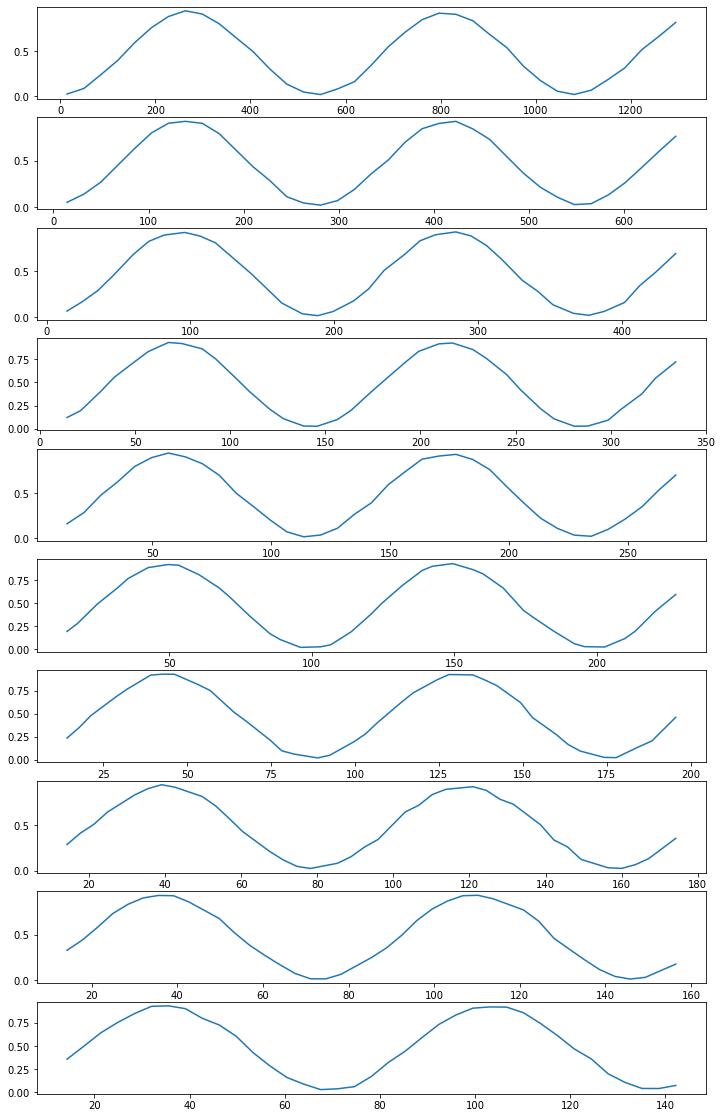

In [27]:
fig,ax = plt.subplots(nrows = len(pulse_amp_array), ncols = 1, figsize = (12,20))
for i in range(len(pulse_amp_array)):
    ax[i].plot(pulse_times[i]*dt*1e9, rabi_oscillations_results[i])

In [33]:
rabi_calibration_exp_I = []
bound_list = [[[0.9, 0.5e6],[1, 1e6]],
[[0.9, 20],[1, 3e6]],
[[0.9, 20],[1, 4e6]],
[[0.9, 20],[1, 5e6]],
[[0.9, 0.5e6],[1, 10e6]],
[[0.9, 0.5e6],[1, 10e6]],
[[0.9, 0.5e6],[1, 10e6]],
[[0.9, 0.5e6],[1, 10e6]],
[[0.9, 0.5e6],[1, 10e6]],
[[0.9, 0.5e6],[1, 10e6]]]
for i in range(len(pulse_amp_array)):
    time_array = pulse_times[i]*dt
    rabi_values = rabi_oscillations_results[i]
    fit_parameters2, y_fit = fit_function(time_array, rabi_values, lambda x, A, rabi_freq: A * np.cos(2 * np.pi * rabi_freq * x + np.pi/2) ** 2, (bound_list[i][0], bound_list[i][1]))
    rabi_calibration_exp_I.append(2 * fit_parameters2[1])


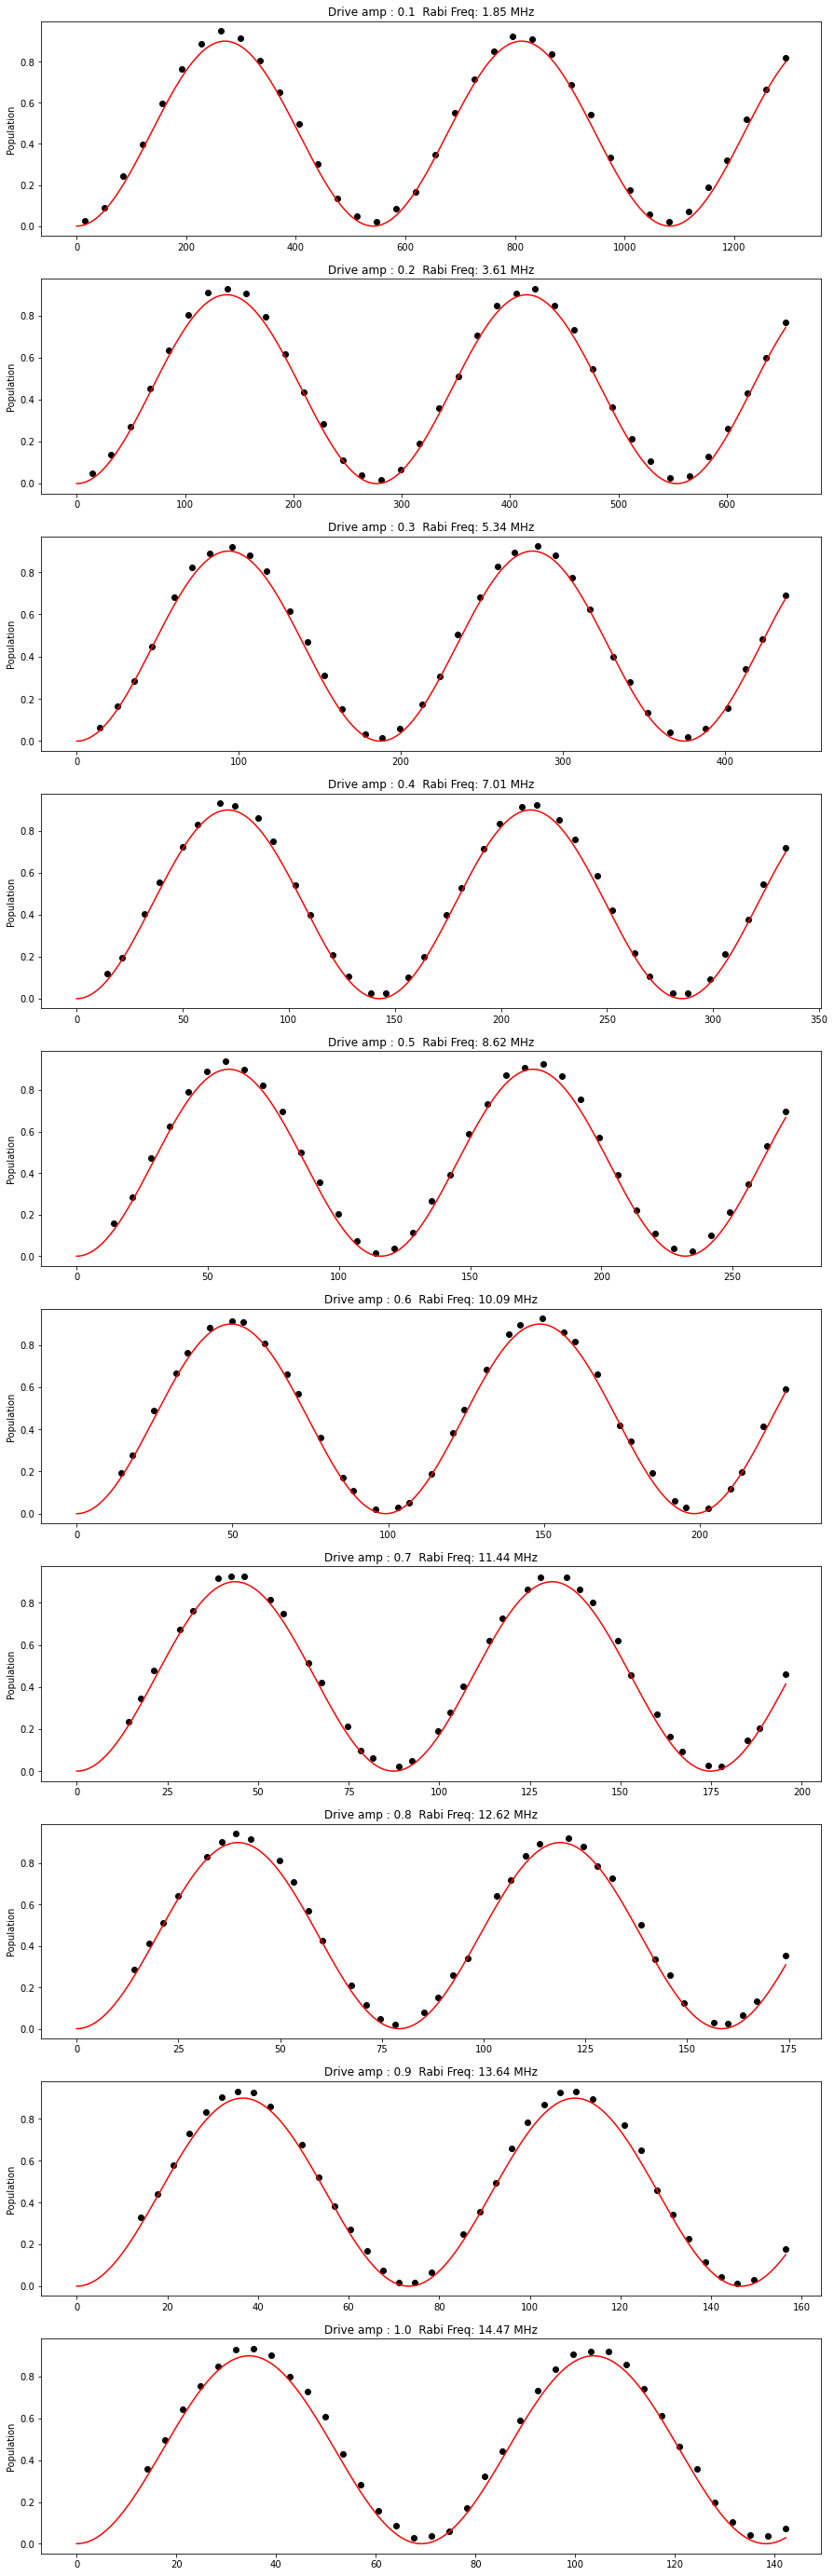

In [36]:
fig, ax = plt.subplots(nrows=len(pulse_amp_array), ncols=1, figsize=(15, 5 * len(pulse_amp_array)))
for num in range(len(pulse_amp_array)):
    rabi_values = rabi_oscillations_results[num]
    time_array = pulse_times[num] * dt
    plot_times = np.linspace(0, time_array[-1], 600)
    fit_parameters = rabi_calibration_exp_I[num]
    ax[num].scatter(time_array * 1e9, np.real(rabi_values), color='black')
    ax[num].plot(plot_times*1e9, 0.9* np.cos(1 * np.pi * fit_parameters * plot_times + np.pi/2) ** 2,color="red")
    ax[num].set_title("Drive amp : {:.1f}  Rabi Freq: {:.2f} MHz".format(pulse_amp_array[num],fit_parameters/1e6))
    # ax[num].set_xlabel("Time")
    ax[num].set_ylabel("Population")


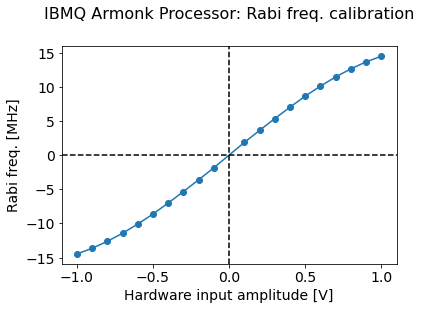

In [39]:
amplitude_interpolated_list = np.linspace(-1., 1., 100)
pulse_amp_array2 = np.concatenate((-pulse_amp_array[::-1], pulse_amp_array))
rabi_calibration_exp_I2 = np.concatenate(
    (-np.asarray(rabi_calibration_exp_I[::-1]), np.asarray(rabi_calibration_exp_I))
)
f_amp_to_rabi = interpolate.interp1d(pulse_amp_array2, rabi_calibration_exp_I2)
rabi_interpolated_exp_I = f_amp_to_rabi(amplitude_interpolated_list)

f_rabi_to_amp = interpolate.interp1d(
    rabi_interpolated_exp_I, amplitude_interpolated_list
)

plt.title("IBMQ Armonk Processor: Rabi freq. calibration", fontsize=16, y=1.1)
plt.xlabel("Hardware input amplitude [V]", fontsize=14)
plt.ylabel("Rabi freq. [MHz]", fontsize=14)
plt.scatter(pulse_amp_array2, rabi_calibration_exp_I2/1e6)
plt.tick_params(axis="both", which="major", labelsize=14)
plt.plot(amplitude_interpolated_list, rabi_interpolated_exp_I/1e6)
plt.axvline(0, color="black", linestyle="dashed")
plt.axhline(0, color="black", linestyle="dashed")
plt.show()

In [11]:
import scipy.signal as sp
def pulse_compile(complex_pulse_array, sampling_time, IQ_convert, hardware_dt):
    number_of_segments = len(complex_pulse_array)
    duration = len(complex_pulse_array) * sampling_time
    duration_int = int(round(duration/hardware_dt))
    segment_scale = duration_int / number_of_segments

    I_values = np.real(complex_pulse_array) / 2 / np.pi
    Q_values = np.imag(complex_pulse_array) / 2 / np.pi

    A_I_values = np.repeat(IQ_convert(I_values), segment_scale)
    A_Q_values = np.repeat(IQ_convert(Q_values), segment_scale)

    return A_I_values + 1j * A_Q_values

import scipy.signal as sp
def drag_generator_ns(sigma_ns, length_ns, alpha):
    gaussian = sp.gaussian(length_ns, sigma_ns)
    gaussian = gaussian - gaussian[0]
    omega_I = gaussian
    omega_Q = alpha * np.gradient(omega_I)
    omega = omega_I + 1j*omega_Q
    a_omega = np.sqrt(omega_I**2 + omega_Q**2)
    area = np.trapz(a_omega)
    omega = np.pi * omega / (area) * 1e9
    return omega

length = 16*6
sigma = length/6
drag_pulse = drag_generator_ns(sigma, length, 2)
drag_waveform = pulse_compile(drag_pulse, 1 * 1e-9, f_rabi_to_amp, dt)
drive_sample_number = len(drag_waveform)
drive_sample_step_size = dt
drive_time_list = np.arange(0,drive_sample_step_size * drive_sample_number, drive_sample_step_size)

fig, ax = plt.subplots(figsize=(10,8))
ax.plot(drive_time_list * 1e9, np.real(drag_waveform),label="I")
ax.plot(drive_time_list * 1e9, np.imag(drag_waveform),label="Q")
ax.set_xlabel("Time[ns]")
ax.set_ylabel("Hardware drive[V]")
ax.set_title("96ns DRAG Pulse")
ax.legend()
ax.grid()

NameError: name 'f_rabi_to_amp' is not defined

In [12]:
from scipy.interpolate import CubicSpline
import qutip as qt

def driven_hamiltonian_ns(omega, free_hamiltonian, qubit_x, qubit_y, plot=False):
    tlist = np.linspace(0, len(omega), len(omega))
    qubit_I = np.real(omega) * 0.9582815089328248 / 2
    qubit_Q = np.imag(omega) * 0.9582815089328248 / 2

    H_drive = qubit_x, qubit_y

    pulse_array = np.array([qubit_I, qubit_Q])

    def make_interpolation(id):
        def _function(t, args=None):
            return CubicSpline(tlist, pulse_array[id], bc_type="clamped")(t)

        return _function

    H0 = free_hamiltonian
    Ht_list = []
    Ht_list.append(H0)

    for ii in range(2):
        Ht_list.append([H_drive[ii], make_interpolation(ii)])

    if plot:
        fig, ax = plt.subplots(1, 1, figsize=(12, 10))
        ax.plot(tlist, Ht_list[1][1](tlist) * 1e3 / (2 * np.pi))
        ax.plot(tlist, Ht_list[2][1](tlist) * 1e3 / (2 * np.pi))
        ax.legend(("Real", "Imag"), prop={'size':15})
        ax.set_title("Qubit Drive", fontsize=15)
        ax.set_xlabel("Time[ns]", fontsize=15)
        ax.set_ylabel("$\Omega$[MHz]", fontsize=15)

    return Ht_list

nq = 10
g = qt.basis(nq,0)
e = qt.basis(nq,1)
f = qt.basis(nq, 2)
h = qt.basis(nq, 3)

psi0 = g

b = qt.destroy(nq)

qubit_x = b + b.dag()
qubit_y = -1j * (b - b.dag())
qubit_z = 2 * b.dag() * b - qt.qeye(nq)
g_state_projector = g * g.dag()
e_state_projector = e * e.dag()
f_state_projector = f * f.dag()

e_ops = [qubit_x, qubit_y, qubit_z, g_state_projector, e_state_projector, f_state_projector]
c_ops = []

def plot_bloch_vector_component(tlist, bloch_array):
    fig, ax = plt.subplots(figsize=(12, 5))
    tlist2 = tlist
    ax.plot(tlist2, bloch_array[0])
    ax.plot(tlist2, bloch_array[1])
    ax.plot(tlist2, bloch_array[2])
    ax.legend(("x", "y", "z"), prop={'size':15})
    ax.set_title("Bloch Sphere Component", fontsize=15)
    plt.xlabel("Time[ns]", fontsize=15)


def plot_population(tlist, p_list):
    fig, ax = plt.subplots(figsize=(12, 5))
    tlist2 = tlist
    ax.plot(tlist2, p_list[0])
    ax.plot(tlist2, p_list[1])
    ax.plot(tlist2, p_list[2])
    ax.legend(("g", "e", "f"), prop={'size':15})
    ax.set_title("Qubit State Population", fontsize=15)
    plt.xlabel("Time[ns]", fontsize=15)


h_bar = 1
alpha_mhz = 347.2
# qubit_frequency_ghz = 2 * np.pi * 5
alpha = 2 * np.pi * alpha_mhz / 10000 # 200 MHz Our time unit is 0.1ns -> 10GHz for the frequency.

transmon_hamiltonian = - h_bar * alpha / 2 * b.dag() * b.dag() * b * b

X Gate Fidelity:  0.9935216419585621


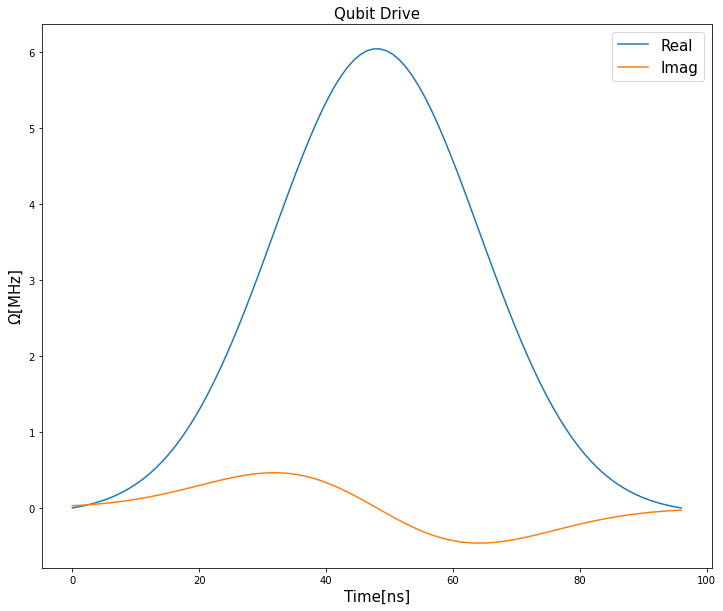

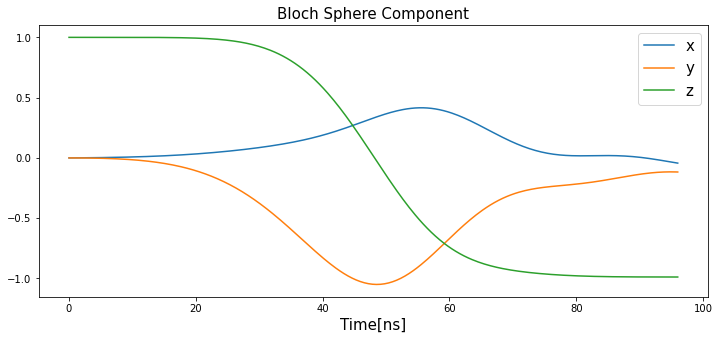

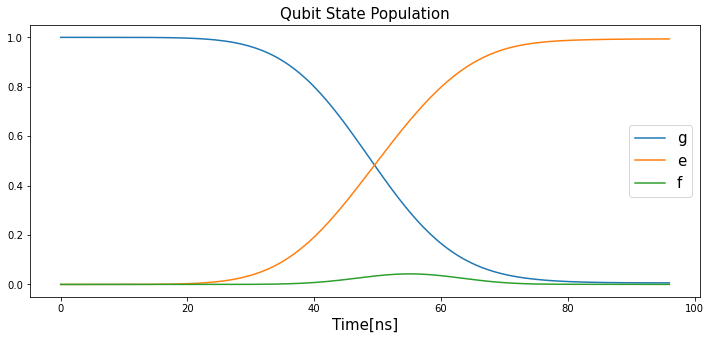

In [13]:
omega = drag_pulse /1e9
tlist = np.linspace(0, len(omega), 300)

pi_hamiltonian = driven_hamiltonian_ns(omega=omega, free_hamiltonian=transmon_hamiltonian, qubit_x = qubit_x, qubit_y = qubit_y, plot=True)
res = qt.mesolve(pi_hamiltonian,psi0,tlist,c_ops=c_ops, e_ops=e_ops, options=qt.Options(store_states=True))
bvec_array = [res.expect[0],res.expect[1],-res.expect[2]]
plist = [res.expect[3], res.expect[4], res.expect[5]]
plot_bloch_vector_component(tlist=tlist, bloch_array=bvec_array)
plot_population(tlist=tlist, p_list=plist)
print("X Gate Fidelity: ", plist[1][-1])

C:\Users\soohw\AppData\Local\Temp\ipykernel_16388\3450436707.py:57: DeprecationWarning: Passing a Qobj to Backend.run is deprecated and will be removed in a future release. Please pass in circuits or pulse schedules instead.
  job = backend.run(pulse_evolution_program)


Job Status: job has successfully run


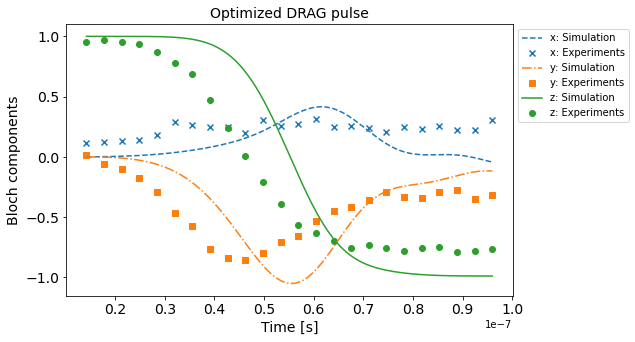

In [52]:
# Creating IBM schedules
import matplotlib.gridspec as gridspec
from qiskit.pulse.library import Waveform
bloch_basis = ["x", "y", "z"]

ibm_evolution_times = {}
times_int = {}
pulse_evolution_program = {}
time_min = 64
time_step = 16

complex_pulse_array = drag_pulse
sampling_time = 1e-9
hardware_dt = dt

number_of_segments = len(complex_pulse_array)
duration = len(complex_pulse_array) * sampling_time
duration_int = int(round(duration/hardware_dt))
segment_scale = duration_int / number_of_segments

time_max = int(segment_scale * number_of_segments)
times_int = np.arange(time_min, time_max + time_step, time_step)
ibm_evolution_times = times_int * dt

evolution_schedules = []
for meas_basis in bloch_basis:
    for time_idx in times_int:
        schedule = pulse.Schedule(
            name="Basis_%s_duration_%d" % (meas_basis, time_idx)
        )
        schedule += Play(Waveform(drag_waveform[:time_idx]), drive_chan)
        if meas_basis == "x":
            schedule += inst_sched_map.get("u2", [0], P0=0.0, P1=np.pi)
            schedule += measure_schedule << schedule.duration
        if meas_basis == "y":
            schedule += inst_sched_map.get("u2", [0], P0=0.0, P1=np.pi / 2)
            schedule += measure_schedule << schedule.duration
        if meas_basis == "z":
            schedule += measure_schedule << schedule.duration
        evolution_schedules.append(schedule)

pulse_evolution_program = assemble(
    evolution_schedules,
    backend=backend,
    meas_level=2,
    meas_return="single",
    shots=num_shots_per_point,
    # schedule_los=[{drive_chan: qubit_frequency}]
    # * len(times_int[scheme_name])
    # * 3,
)


# Running the jobs
evolution_exp_results = {}

job = backend.run(pulse_evolution_program)
job_monitor(job)
evolution_exp_results = job.result(timeout=120)

# Extract results
evolution_results_ibm = {}
evolution_basis = {}
for meas_basis in bloch_basis:
    evolution_exp_data = np.zeros(len(times_int))
    for idx, time_idx in enumerate(times_int):
        counts = evolution_exp_results.get_counts(
            "Basis_%s_duration_%d" % (meas_basis, time_idx)
        )
        excited_pop = 0
        for bits, count in counts.items():
            excited_pop += count if bits[::-1][qubit] == "1" else 0
        evolution_exp_data[idx] = excited_pop / num_shots_per_point
    evolution_basis[meas_basis] = evolution_exp_data
evolution_results_ibm = evolution_basis

# Plotting parameters

markers = {"x": "x", "y": "s", "z": "o"}
lines = {"x": "--", "y": "-.", "z": "-"}


simulated_bloch = {'x':bvec_array[0], 'y':bvec_array[1], 'z':bvec_array[2]}
simulation_time_array = np.linspace(ibm_evolution_times[0], ibm_evolution_times[-1], len(bvec_array[0]))
gate_times = {}
infidelities = {}

# Plotting
gs = gridspec.GridSpec(1, 1, hspace=0.5)
fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(8)


ax = fig.add_subplot()
for meas_basis in bloch_basis:
    ax.plot(
            simulation_time_array,
            simulated_bloch[meas_basis],
            ls=lines[meas_basis],
            label="%s: Simulation" % (meas_basis),
        )
    ax.scatter(
        ibm_evolution_times,
        1 - 2 * evolution_results_ibm[meas_basis],
        label="%s: Experiments" % (meas_basis),
        marker=markers[meas_basis],
    )
ax.set_title("Optimized DRAG pulse", fontsize=14)
ax.set_xlabel("Time [s]", fontsize=14)
ax.set_ylabel("Bloch components", fontsize=14)
ax.tick_params(labelsize=14)
ax.legend(loc="best", bbox_to_anchor=(1, 1))

plt.show()


Job Status: job has successfully run


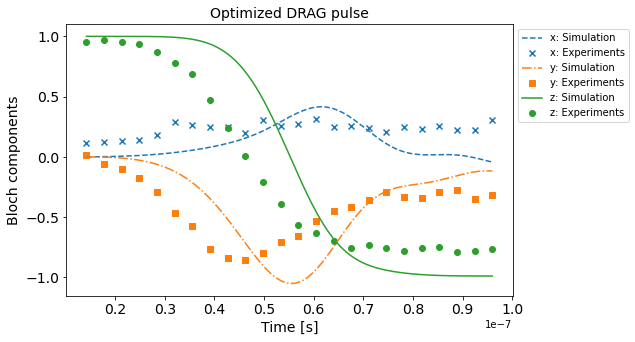

In [18]:
# Creating IBM schedules
num_shots_per_point = 1024
import matplotlib.gridspec as gridspec
from qiskit.pulse.library import Waveform
bloch_basis = ["x", "y", "z"]




# Running the jobs
evolution_exp_results = {}

job = backend.retrieve_job("62a29b901453e07a4ff5070c")
job_monitor(job)
evolution_exp_results = job.result(timeout=120)

# Extract results
evolution_results_ibm = {}
evolution_basis = {}
for meas_basis in bloch_basis:
    evolution_exp_data = np.zeros(len(times_int))
    for idx, time_idx in enumerate(times_int):
        counts = evolution_exp_results.get_counts(
            "Basis_%s_duration_%d" % (meas_basis, time_idx)
        )
        excited_pop = 0
        for bits, count in counts.items():
            excited_pop += count if bits[::-1][qubit] == "1" else 0
        evolution_exp_data[idx] = excited_pop / num_shots_per_point
    evolution_basis[meas_basis] = evolution_exp_data
evolution_results_ibm = evolution_basis

# Plotting parameters

markers = {"x": "x", "y": "s", "z": "o"}
lines = {"x": "--", "y": "-.", "z": "-"}


simulated_bloch = {'x':bvec_array[0], 'y':bvec_array[1], 'z':bvec_array[2]}
simulation_time_array = np.linspace(ibm_evolution_times[0], ibm_evolution_times[-1], len(bvec_array[0]))
gate_times = {}
infidelities = {}

# Plotting
gs = gridspec.GridSpec(1, 1, hspace=0.5)
fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(8)


ax = fig.add_subplot()
for meas_basis in bloch_basis:
    ax.plot(
            simulation_time_array,
            simulated_bloch[meas_basis],
            ls=lines[meas_basis],
            label="%s: Simulation" % (meas_basis),
        )
    ax.scatter(
        ibm_evolution_times,
        1 - 2 * evolution_results_ibm[meas_basis],
        label="%s: Experiments" % (meas_basis),
        marker=markers[meas_basis],
    )
ax.set_title("Optimized DRAG pulse", fontsize=14)
ax.set_xlabel("Time [s]", fontsize=14)
ax.set_ylabel("Bloch components", fontsize=14)
ax.tick_params(labelsize=14)
ax.legend(loc="best", bbox_to_anchor=(1, 1))

plt.show()

In [19]:
1 - 2 * evolution_results_ibm["z"]

array([ 0.95507812,  0.97070312,  0.953125  ,  0.93945312,  0.87304688,
        0.78125   ,  0.68945312,  0.47265625,  0.23632812,  0.0078125 ,
       -0.20507812, -0.39453125, -0.56835938, -0.6328125 , -0.69921875,
       -0.7578125 , -0.73046875, -0.75195312, -0.77734375, -0.7578125 ,
       -0.75      , -0.79101562, -0.78320312, -0.76757812])